In [14]:
library(randomForest())
library(caret)
library(ggplot2)
library(Metrics)
library(reshape2)

In [15]:
df <- read.csv("../../../Cleaned Datasets/rebate_cleaned.csv")
set.seed(42)

train_index <- createDataPartition(df$`Rebate.Amount..USD.`, p = 0.7, list = FALSE)

train_data <- df[train_index, ]
test_data <- df[-train_index, ]

train_data$`Rebate.Amount..USD.` <- factor(train_data$`Rebate.Amount..USD.`)
test_data$`Rebate.Amount..USD.` <- factor(test_data$`Rebate.Amount..USD.`)

In [16]:
set.seed(42)

num_predictors <- length(names(train_data)) - 1
mtry_sqrt <- floor(sqrt(num_predictors))

model <- randomForest(`Rebate.Amount..USD.`  ~ ., data = train_data, ntree = 30, 
            mtry = mtry_sqrt, nodesize=1, maxnodes=15, do.trace=TRUE)

print(model)
summary(model)

ntree      OOB      1      2      3      4
    1:   7.68% 60.09%  0.16%  3.76%  0.60%
    2:   5.10% 34.57%  1.07%  3.46%  0.62%
    3:   5.86% 42.26%  0.67%  4.04%  0.65%
    4:   5.41% 37.76%  0.65%  4.02%  0.84%
    5:   6.93% 35.02%  0.49% 12.78%  1.18%
    6:   6.84% 41.21%  0.39%  9.52%  0.94%
    7:   6.60% 38.06%  0.49%  9.83%  0.92%
    8:   5.79% 33.89%  0.36%  8.45%  0.82%
    9:   5.06% 29.76%  0.28%  7.36%  0.74%
   10:   4.44% 26.62%  0.18%  5.91%  0.94%
   11:   5.03% 30.76%  0.32%  6.40%  0.91%
   12:   4.64% 28.06%  0.27%  5.99%  0.89%
   13:   4.33% 25.78%  0.18%  5.95%  0.86%
   14:   3.94% 23.76%  0.14%  5.26%  0.82%
   15:   3.52% 21.03%  0.14%  4.80%  0.73%
   16:   3.97% 24.03%  0.12%  5.40%  0.75%
   17:   3.73% 22.33%  0.12%  5.28%  0.64%
   18:   3.85% 24.13%  0.12%  4.76%  0.73%
   19:   3.61% 21.86%  0.12%  4.85%  0.71%
   20:   4.04% 26.01%  0.14%  4.67%  0.73%
   21:   4.08% 26.24%  0.12%  4.85%  0.68%
   22:   4.45% 29.42%  0.12%  4.94%  0.71%
   23:   4.

                Length Class  Mode     
call                8  -none- call     
type                1  -none- character
predicted       16223  factor numeric  
err.rate          150  -none- numeric  
confusion          20  -none- numeric  
votes           64892  matrix numeric  
oob.times       16223  -none- numeric  
classes             4  -none- character
importance          8  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             14  -none- list     
y               16223  factor numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [17]:
predictions <- predict(model, test_data)
actual <- test_data$`Rebate.Amount..USD.`

In [18]:
conf_matrix <- confusionMatrix(predictions, actual)

predictions <- factor(predictions, levels = levels(test_data$`Rebate.Amount..USD.`))

cm <- confusionMatrix(predictions, test_data$`Rebate.Amount..USD.`)

precision <- cm$byClass[, 'Precision']
recall <- cm$byClass[, 'Recall']
f1 <- cm$byClass[, 'F1']
accuracy <- cm$overall['Accuracy']

precision <- precision[!is.na(precision)]
recall <- recall[!is.na(recall)]
f1 <- f1[!is.na(f1)]

avg_precision <- mean(precision)
avg_recall <- mean(recall)
avg_f1 <- mean(f1)

print(paste("Accuracy:", accuracy))
print(paste("Average Precision:", avg_precision))
print(paste("Average Recall:", avg_recall))
print(paste("Average F1 Score:", avg_f1))

[1] "Accuracy: 0.970939433175083"
[1] "Average Precision: 0.975473056164328"
[1] "Average Recall: 0.946294545244095"
[1] "Average F1 Score: 0.958718211488727"


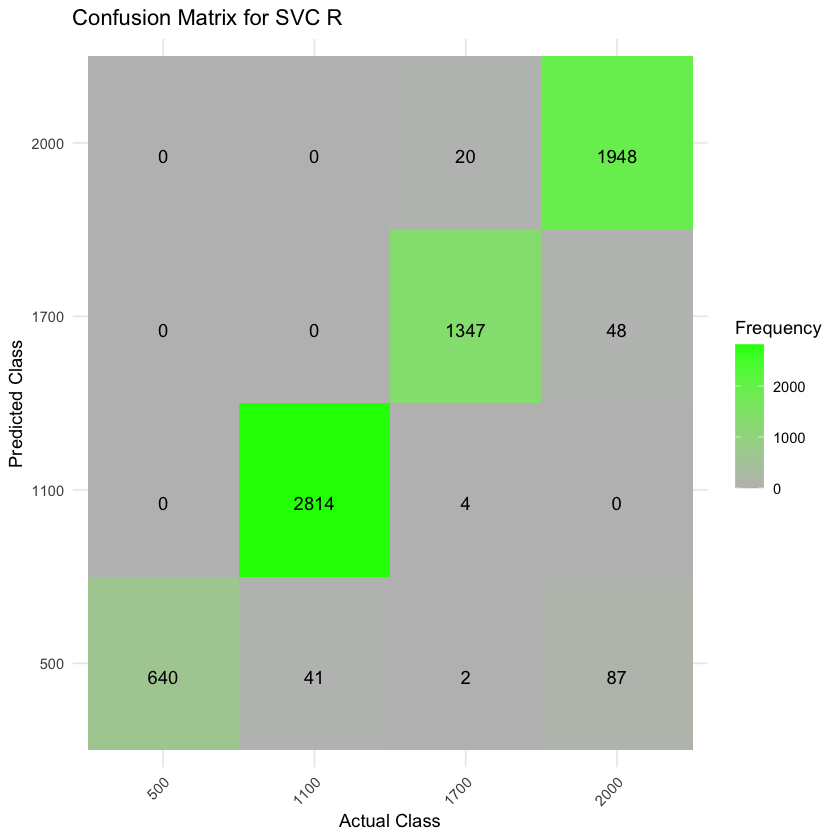

In [19]:
conf_mat <- as.matrix(conf_matrix$table)
conf_data <- as.data.frame(melt(conf_mat))
names(conf_data) <- c("Reference", "Prediction", "Frequency")

custom_labels <- c('500', '1100', '1700', '2000')

conf_data$Reference <- factor(conf_data$Reference, levels = unique(conf_data$Reference), labels = custom_labels)
conf_data$Prediction <- factor(conf_data$Prediction, levels = unique(conf_data$Prediction), labels = custom_labels)

 ggplot(conf_data, aes(x = Reference, y = Prediction, fill = Frequency)) +
    geom_tile() +
    geom_text(aes(label = Frequency), vjust = 1.5, color = "black") +
    scale_fill_gradient(low = "grey", high = "green") +
    labs(title = "Confusion Matrix for SVC R", x = "Actual Class", y = "Predicted Class") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text.y = element_text(angle = 0)) + 
    scale_x_discrete(labels = custom_labels) +
    scale_y_discrete(labels = custom_labels)


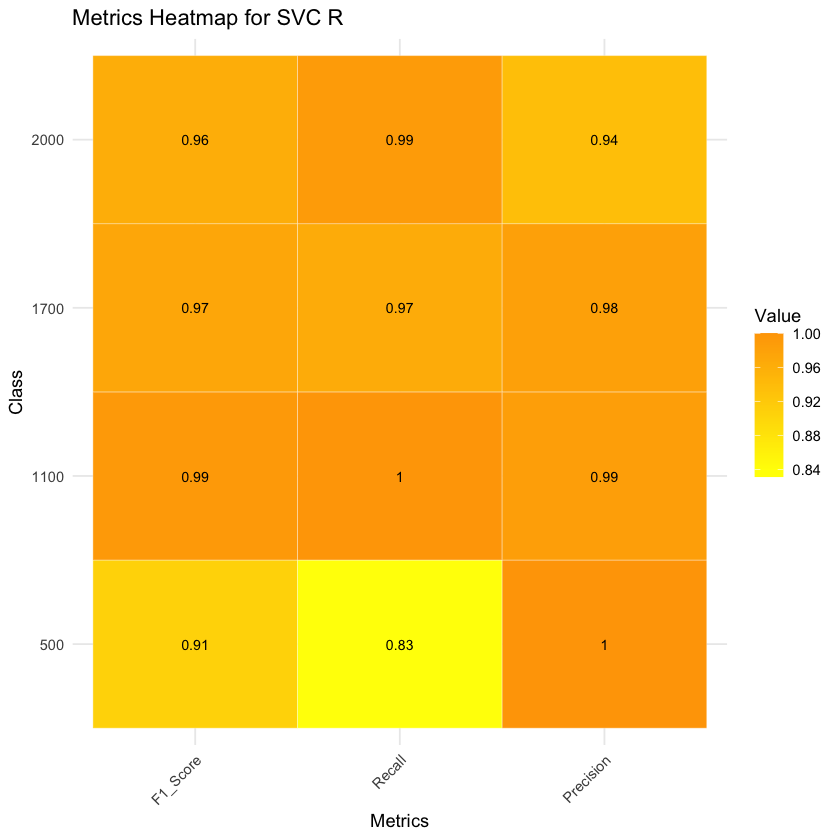

In [20]:
f1 <- cm[["byClass"]][ , "F1"]
recall <- cm[["byClass"]][ , "Recall"]
precision <- cm[["byClass"]][ , "Precision"]

metrics_df <- data.frame(Class = rownames(cm[["byClass"]]), F1_Score = f1, Recall = recall, Precision = precision)

metrics_melted <- melt(metrics_df, id.vars = "Class", variable.name = "Metric", value.name = "Value")

metrics_melted$Class <- factor(metrics_melted$Class, levels = unique(metrics_melted$Class))

custom_labels <- c('500','1100','1700','2000')

ggplot(metrics_melted, aes(x = Metric, y = Class, fill = Value, label = round(Value, 2))) +
  geom_tile(color = "white") +
  geom_text(color = "black", size = 3) +
  scale_fill_gradient(low = "yellow", high = "orange") +
  labs(title = "Metrics Heatmap for SVC R", x = "Metrics", y = "Class") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  scale_y_discrete(labels = custom_labels) 